# Running a Surface wetting Workflow with flowerMD

## Overview:

This notebook demonstrates how to run a surface wetting workflow with flowerMD. For demonstration purposes, we will create a Poly(ethylene) droplet on a graphene surface. The workflow consists of the following steps:

1. Create a droplet of the polymer melt
2. Create a graphene surface
3. Combine the droplet and surface into a single system
4. Run wetting simulation

## Step 1: Create a droplet

Let's start by creating a Poly(ethylene) droplet. We will use the `PolyEthylene` class from the `flowermd.library.polymers` module to create a Poly(ethylene) melt. We will then use the `Pack` class from the `flowermd.base.system` module to create the system.

Next step is to start the droplet simulation by using the `DropletSimulation` class from the `flowermd.modules.surface_wetting` module. We will use the `DropletSimulation.from_system` method to create the simulation object from the system object. This method will automatically create the simulation object with the correct parameters for the droplet simulation.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()


In [ ]:
!mamba install flowermd

In [1]:
from cmeutils.visualize import FresnelGSD
import unyt
import warnings
import os

warnings.filterwarnings('ignore')

In [2]:
from flowermd.base.system import Pack
from flowermd.library.polymers import PolyEthylene
from flowermd.library.forcefields import OPLS_AA

/home/chris/mambaforge/envs/flowermd-dev/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


In [3]:
polyethylene = PolyEthylene(num_mols=70, lengths=25)
droplet_system = Pack(molecules=polyethylene, density=1.0 * unyt.g/unyt.cm**3)
droplet_system.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    remove_hydrogens=True,
    auto_scale=True,
    r_cut=2.5
)

No charged group detected, skipping electrostatics.


In [4]:
from flowermd.modules.surface_wetting import DropletSimulation

droplet_sim = DropletSimulation.from_system(
    droplet_system,
    gsd_file_name="droplet_trajectory.gsd",
    log_file_name="droplet_sim_data.txt"
)

Initializing simulation state from a gsd.hoomd.Frame.


**Note: Saving and reusing forces from a simulation:**

We created the set of Hoomd forces needed to simulate polyethylene in `DropletSimulation`.
In a later simulation, we will be simulating polyethylene again, so we can save the Hoomd force objects here for quick loading in another simulation.
Also, we will save the reference units used for polyethylene, which came from our choice of forcefield.

In [5]:
droplet_ref_values = droplet_sim.reference_values
droplet_sim.pickle_forcefield("polyethylene_forces.pickle")

<div class="alert alert-block alert-warning"><b>Warning:</b> Due to the large system size, the following cell may take approximately 30 minutes to an hour to run.</div>

**Run the droplet simulation:**

The `run_droplet` method runs the droplet simulation. The method takes the following steps:
1. Shrink the box to a high density at a high temperature. This allows the polymer chains to pack tightly.
2. Expand the box to a low density at a low temperature. This allows the polymer chains to relax and form a droplet.
3. Hold the box at a low density at a low temperature. This allows the droplet to equilibrate.

In [ ]:
# Uncomment the code-block below to try creating a polymer droplet.

"""
droplet_sim.run_droplet(
    tau_kt=droplet_sim.dt * 100,
    shrink_kT=5.0,
    shrink_steps=1e6,
    shrink_period=1000,
    shrink_density=1.4,
    expand_kT=0.5,
    expand_steps=2e6,
    expand_period=1000,
    hold_kT=0.5,
    hold_steps=1e5,
    final_density=0.05
)
droplet_sim.flush_writers()
"""

<div class="alert alert-block alert-info"> <b>Note:</b> In order to reach the perfect droplet shape, you might need to try different parameters (e.g. system size, density, and temperatures) and check the trajectory to see if the droplet is forming.
</div>


For demonstration purposes and to save time, we will use the pre-run droplet simulation snapshot for the above system, saved in the `data` directory.

In [6]:
import gsd.hoomd
import pickle

!wget https://github.com/mosdef-hub/FOMMS-MoSDeF-Workshop/raw/main/polymers/polyethylene_droplet.gsd
droplet_snapshot = gsd.hoomd.open('polyethylene_droplet.gsd')[0]



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://github.com/mosdef-hub/]870 files                0% [<=>                           ]       0          B/s87[Files: 0  Bytes: 0  [0 B/s] Re]870 files                0% [ <=>                          ]       0          B/s87[https://raw.githubusercontent.]87polyethylene_droplet  10% [==>                           ]   31.98K    --.-KB/s87polyethylene_droplet  51% [==============>               ]  159.98K    1.00MB/s87polyethylene_droplet  82% [=======================>      ]  256.00K  597.37KB/s87polyethylene_droplet 100% [=============================>]  312.04K  738.94KB/s87[Files: 1  Bytes: 312.04K [191.]8

Here is a visualization of the droplet:

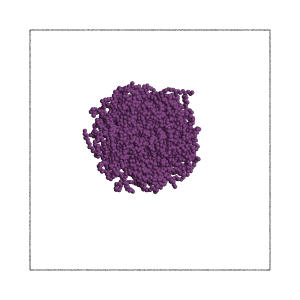

In [7]:
sim_viewer = FresnelGSD(gsd_file="polyethylene_droplet.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

## Step 2: Create a graphene surface

We will use the `Graphene` class from the `flowermd.library.surfaces` to create a graphene surface. The size of the graphene surface is determined by the `x_repeat` and `y_repeat` parameters, which determine the number of unit cells in the x and y directions, respectively.  The `n_layers` parameter determines the number of graphene layers.
This class is a subclass of `System` base class, so we can use the `apply_forcefield` method to apply the force field to the graphene surface.

**Note**: We are using the droplet system's reference values to scale the graphene surface. This ensures that the graphene surface and the droplet system have the same units. Make sure to set the `auto_scale` parameter to `False` when applying the force field to the graphene surface.

In [ ]:
from flowermd.library.surfaces import Graphene

graphene = Graphene(
    x_repeat=30,
    y_repeat=30,
    n_layers=2,
    base_units=droplet_ref_values
)
graphene.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    auto_scale=False,
    r_cut=2.5
)

No charged group detected, skipping electrostatics.


## Step 3: Combine the droplet and surface systems

The `InterfaceBuilder` class from the `flowermd.modules.surface_wetting` module combines the droplet and surface snapshots by placing the droplet particles on top of the surface. The particles are placed in a box with a height equal to the `box_height` parameter. The `gap` parameter determines the distance between the droplet and the surface.

This class also combines the force fields of the droplet and surface systems, while also accounting for new LJ interactions between the droplet and surface particles.


In [ ]:
with open("polyethylene_forces.pickle" "rb") as f:
    droplet_ff = pickle.load(f)

In [ ]:
from flowermd.modules.surface_wetting import InterfaceBuilder
import unyt as u

interface = InterfaceBuilder(
    surface_snapshot=graphene.hoomd_snapshot,
    surface_ff=graphene.hoomd_forcefield,
    drop_snapshot=droplet_snapshot,
    drop_ff=droplet_ff,
    drop_ref_values=droplet_ref_values,
    box_height=12 * u.nm,
    gap=0.4 * u.nm
)

The new snapshot and force field can be accessed using the `hoomd_snapshot` and `hoomd_forcefield` attributes, respectively.

In [ ]:
wetting_snapshot = interface.hoomd_snapshot
wetting_forcefield = interface.hoomd_forces

In [ ]:
# save the `wetting_snapshot` to a gsd file
with gsd.hoomd.open("surface_wetting_init.gsd", "w") as traj:
    traj.append(wetting_snapshot)

Let's visualize the new snapshot containing the droplet and surface particles.

In [ ]:
sim_viewer = FresnelGSD(gsd_file="surface_wetting_init.gsd", view_axis=(0, 1.5, 0), frame=-1)
sim_viewer.view()

## Step 4: Run wetting simulation

The `WettingSimulation` class from the `flowermd.modules.surface_wetting` module runs the wetting simulation. The `WettingSimulation` class is a subclass of the `Simulation` base class. The `WettingSimulation` class takes the following parameters:
- `initial_state`: The snapshot containing the droplet and surface particles.
- `forcefield`: The force field containing the droplet and surface force fields.
- `fix_surface`: A boolean value that determines whether the surface particles are fixed during the simulation. If `True`, the surface particles are excluded from the integrator, meaning that they will not move during the simulation.

In [ ]:
from flowermd.modules.surface_wetting import WettingSimulation

wetting_sim = WettingSimulation(
    initial_state=wetting_snapshot,
    forcefield=wetting_forcefield,
    fix_surface=True,
    gsd_file_name="wetting_trajectory.gsd",
    log_file_name="wetting_sim_data.txt"
)

Now we can start the wetting simulation by using the `run_NVT` method. The droplet slowly spreads on the surface, and eventually wets the surface.

<div class="alert alert-block alert-warning"><b>Warning:</b> Due to the large system size, the following cells may take approximately 30 minutes to an hour to run.</div>

In [ ]:
# Uncomment to run surface wetting simulation

#wetting_sim.run_NVT(kT=3.0, n_steps=3e5, tau_kt=wetting_sim.dt*100)
#wetting_sim.flush_writers()

In [ ]:
sim_viewer = FresnelGSD(gsd_file="wetting_trajectory.gsd", view_axis=(0, 1.5, 0), frame=-1)
sim_viewer.view()

In [ ]:
# Uncomment to run the surface wetting simulation longer:

#wetting_sim.run_NVT(kT=3.0, n_steps=2e5, tau_kt=wetting_sim.dt*100)
#wetting_sim.flush_writers()

In [ ]:
sim_viewer = FresnelGSD(gsd_file="wetting_trajectory.gsd", view_axis=(0, 1.5, 0), frame=-1)
sim_viewer.view()

**Workflow summary:**

In [ ]:
polyethylene = PolyEthylene(num_mols=70, lengths=25)
droplet_system = Pack(molecules=polyethylene, density=1.0 * unyt.g/unyt.cm**3)
droplet_system.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    remove_hydrogens=True,
    auto_scale=True,
    r_cut=2.5
)

droplet_sim = DropletSimulation.from_system(
    droplet_system,
    gsd_file_name="droplet_trajectory.gsd",
    log_file_name="droplet_sim_data.txt"
)
droplet_ref_values = droplet_sim.reference_values
droplet_sim.pickle_forcefield("polyethylene_forces.pickle")
droplet_snapshot = gsd.hoomd.open('polyethylene_droplet.gsd')[0]

graphene = Graphene(
    x_repeat=30,
    y_repeat=30,
    n_layers=2,
    base_units=droplet_ref_values
)
graphene.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    auto_scale=False,
    r_cut=2.5
)

interface = InterfaceBuilder(
    surface_snapshot=graphene.hoomd_snapshot,
    surface_ff=graphene.hoomd_forcefield,
    drop_snapshot=droplet_snapshot,
    drop_ff=droplet_ff,
    drop_ref_values=droplet_ref_values,
    box_height=12 * u.nm,
    gap=0.4 * u.nm
)

wetting_snapshot = interface.hoomd_snapshot
wetting_forcefield = interface.hoomd_forces

wetting_sim = WettingSimulation(
    initial_state=wetting_snapshot,
    forcefield=wetting_forcefield,
    fix_surface=True,
    gsd_file_name="wetting_trajectory.gsd",
    log_file_name="wetting_sim_data.txt"
)